# Tutorial

This tutorial demonstrates the most important features of the `flux-data-qaqc` Python package for management, analysis, and visualization of eddy covariance time series data. It is recommended to read the [Installation](https://flux-data-qaqc.readthedocs.io/en/latest/install.html#installation) and [Configuration Options](https://flux-data-qaqc.readthedocs.io/en/latest/advanced_config_options.html#configuration-options-and-caveats) tutorials before this one. 

**Tip:** currently, the software does not include a command line interface therefore to use the software you must use Python, e.g. make your own scripts or use an interactive shell. However, you will see that common workflows can be accomplished with a few (5-10) lines of code and you can simply follow the templates given here to make custom scripts.

## Description of example datasets

The data for this example comes from the "Twitchell Alfalfa" AmeriFlux eddy
covariance flux tower site in California. The site is located in alfalfa fields and exhibits a mild Mediterranean climate with dry and hot summers, for more information on this site or to download data click [here](https://ameriflux.lbl.gov/sites/siteinfo/US-Tw3). 

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from fluxdataqaqc import Data, QaQc, Plot
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models import LinearAxis, Range1d
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## Loading input

The loading and management of input climatic data and metadata from a config.ini file is done using the ``fluxdataqaqc.Data`` object. In a nutshell, a ``Data`` object is created from a properly formatted config file (see [Setting up a config file](https://flux-data-qaqc.readthedocs.io/en/latest/advanced_config_options.html?#setting-up-a-config-file)) and has tools for parsing input climate data, averaging input climate time series, accessing/managing metadata, flag-based data filtering, and creating interactive visualizations of input data.  

There is only one argument to create a Data object, the path to the config.ini file:

In [178]:
config_path = 'GC_config.ini.txt'
d = Data(config_path)

In [179]:
# get a list of all entries in the METADATA section of the config.ini
d.config.items('METADATA') # access the DATA section the same way

[('climate_file_path', 'FluxData_SolarCorrected25m_ToQAQC.csv'),
 ('station_latitude', '40.1558477'),
 ('station_longitude', '-88.5780047'),
 ('station_elevation', '217'),
 ('missing_data_value', '-9999'),
 ('skiprows', '0'),
 ('date_parser', '%Y-%m-%d %H:%M:%S'),
 ('site_id', 'GC'),
 ('country', 'USA'),
 ('doi_contributor_name', 'Allison Goodwell'),
 ('doi_contributor_role', 'Author'),
 ('doi_contributor_email', 'goodwel2@illinois.edu'),
 ('doi_contributor_institution', 'University of Illinois at Urbana Champaign'),
 ('doi_organization', 'Prairie Research Institute'),
 ('doi_organization_role', 'Sponsor'),
 ('flux_measurements_method', 'Eddy Covariance'),
 ('flux_measurements_variable', 'CO2'),
 ('flux_measurements_operations', 'Continuous operation'),
 ('site_name', 'Goose Creek flux tower'),
 ('igbp', 'CRO'),
 ('igbp_comment', 'corn and soybean rotation, non-irrigated'),
 ('land_ownership', 'private'),
 ('network', 'none'),
 ('reference_paper', 'tbd'),
 ('reference_doi', 'tbd'),
 ('

A useful method is the ``configparser.ConfigParser.get`` which takes the section of the config file and the "option" and returns the value:

In [180]:
d.config.get(section='METADATA', option='site_name')

'Goose Creek flux tower'

In [181]:
d.variables

{'date': 'NewDate',
 'Rn': 'Rn_corr',
 'G': 'shf_Avg(2)',
 'LE': 'LE_li_wpl',
 'H': 'Hc_li',
 'sw_in': 'Short_up_corr',
 'sw_out': 'Short_dn_corr',
 'lw_in': 'Long_up_corr',
 'lw_out': 'Long_dn_corr',
 'rh': 'RH_tmpr_rh_mean',
 'vpd': 'VPD',
 't_avg': 'T_tmpr_rh_mean',
 'ppt': 'Precip_Tot',
 'wd': 'wnd_dir_compass',
 'ws': 'rslt_wnd_spd',
 'theta_1': 'D5TE_VWC_5cm_Avg',
 'theta_2': 'D5TE_VWC_15cm_Avg'}

And, the ``Data.inv_map`` maps the internal to user-defined names if they differ, however this is only created once the data is loaded by calling ``Data.df``. 

In [182]:
# a similar dictionary attribute for input units
d.units

{'Rn': 'w/m2',
 'G': 'w/m2',
 'LE': 'w/m2',
 'H': 'w/m2',
 'sw_in': 'w/m2',
 'sw_out': 'w/m2',
 'lw_in': 'w/m2',
 'lw_out': 'w/m2',
 'rh': '(%): Relative humidity, range 0-100',
 'vpd': 'kPa',
 't_avg': 'C',
 'ppt': 'mm',
 'wd': 'azimuth (degrees)',
 'ws': 'm/s',
 'theta_1': '(%): Soil water content (volumetric), range 0-100',
 'theta_2': '(%): Soil water content (volumetric), range 0-100'}

#### Accessing input data

The ``Data.df`` property gves access to the time series input climate data for columns specified in the config file as a datetime-indexed ``pandas.DataFrame`` object. This object has numerous powerful built in tools for time series analysis and visualization. 

In [183]:
# first 5 datetimes that are not gaps
d.df.dropna().head()

Calculating mean for var: THETA from columns: ['D5TE_VWC_5cm_Avg', 'D5TE_VWC_15cm_Avg']
Calculating vapor pressure from vapor pressure deficit and air temperature
Calculating dew point temperature from vapor pressure


,rslt_wnd_spd,wnd_dir_compass,LE_li_wpl,Hc_li,Precip_Tot,T_tmpr_rh_mean,RH_tmpr_rh_mean,D5TE_VWC_5cm_Avg,D5TE_VWC_15cm_Avg,shf_Avg(2),VPD,Short_up_corr,Short_dn_corr,Long_up_corr,Long_dn_corr,Rn_corr,theta_mean
date,,,,,,,,,,,,,,,,,
2016-04-22 11:15:00,4.060431,13.493230,111.1646,66.62987,0.0,15.39692,75.43023,0.310,0.303,-3.305334,0.429544,732.8863,85.98323,320.3311,416.5097,550.72447,0.3065
2016-04-22 11:30:00,4.813497,0.842835,233.7630,97.43565,0.0,15.75987,74.24434,0.310,0.303,-1.070949,0.460878,751.1731,88.08359,322.1024,418.6221,566.56981,0.3065
2016-04-22 11:45:00,5.350316,352.704000,150.6655,74.73856,0.0,15.84722,74.90156,0.311,0.303,1.211160,0.451641,751.6536,88.42545,325.2160,419.6883,568.75585,0.3070
2016-04-22 12:00:00,4.717422,5.481720,222.2112,89.94750,0.0,16.14020,77.31715,0.311,0.303,3.689381,0.415887,816.6241,97.11861,336.0214,423.8365,631.69039,0.3070
2016-04-22 12:15:00,4.942996,3.416565,261.9899,99.07247,0.0,16.37151,78.72035,0.311,0.304,6.272957,0.395952,889.4657,106.29350,349.9462,428.3048,704.81360,0.3075


**Tip:** There are *many* tutorials on how to use the ``pandas.DataFrame`` and its powerful data analysis tools for multiple purposes online, to get started you may want to visit Panda's own list of tutorials [here](https://pandas.pydata.org/pandas-docs/stable/getting_started/tutorials.html#internal-guides). 

By default the column names in ``data.df`` are retained from user-defined names unless they were named exactly the same as an internal name. For example the input ground heat flux column in this dataset is named "G", therefore it was renamed as "input_g"

In [184]:
d.df.columns

Index(['rslt_wnd_spd', 'wnd_dir_compass', 'LE_li_wpl', 'Hc_li', 'Precip_Tot',
       'T_tmpr_rh_mean', 'RH_tmpr_rh_mean', 'D5TE_VWC_5cm_Avg',
       'D5TE_VWC_15cm_Avg', 'shf_Avg(2)', 'VPD', 'Short_up_corr',
       'Short_dn_corr', 'Long_up_corr', 'Long_dn_corr', 'Rn_corr',
       'theta_mean', 'vp', 'es', 't_dew'],
      dtype='object')

In [185]:
# the new name was also updated in Data.variables
d.variables.get('G')

'shf_Avg(2)'

As stated earlier, ``Data.inv_map`` maps the user-defined names to internal ``flux-data-qaqc`` names only after loading ``Data.df``:

**Tip:** The ``Data.inv_map`` is mainly used to rename the dataframe to internal names, this can be very useful if you are creating your own custom workflows using the ``flux-data-qaqc`` API because it allows you to only know the internal names of variables therefore they can be hard coded into your workflow and applied to different eddy covariance datasets. For example, let's say we wanted to make HTML tables of basic statistics of just the energy balance components for many datasets (that may have different names for the same variables) and save the file using the user-defined names:

In [186]:
d = Data('GC_config.ini.txt')
df = d.df.rename(columns=d.inv_map)
# get some metadata for saving
site_id = d.site_id
vars_we_want = ['H', 'LE', 'Rn', 'G']
# rename variables, calculate basice statistics table and save to HTML
df[vars_we_want].rename(columns=d.variables).describe().to_html('{}.html'.format(site_id))

Calculating mean for var: THETA from columns: ['D5TE_VWC_5cm_Avg', 'D5TE_VWC_15cm_Avg']
Calculating vapor pressure from vapor pressure deficit and air temperature
Calculating dew point temperature from vapor pressure


In [187]:
# which produces the following HTML table with user-defined names:
from IPython.display import HTML
HTML(filename='{}.html'.format(site_id))

,Hc_li,LE_li_wpl,Rn_corr,shf_Avg(2)
count,174159.000000,174716.000000,218859.000000,218856.000000
mean,22.363992,56.360495,103.196555,-0.434392
std,63.641500,95.225078,214.697727,17.168653
min,-99.976670,-99.899430,-139.540028,-73.475290
25%,-8.321259,0.835151,-44.140831,-11.771467
50%,-0.456343,14.109105,-5.141630,-3.420733
75%,29.996250,70.089923,193.642720,8.534901
max,915.620100,999.265700,943.687940,80.090050


Another powerful feature of the ``Data.df`` property is that it is datetime-indexed using the input data's temporal frequency, view the date index like so:

In [188]:
d.df.index

DatetimeIndex(['2016-04-22 11:15:00', '2016-04-22 11:30:00',
               '2016-04-22 11:45:00', '2016-04-22 12:00:00',
               '2016-04-22 12:15:00', '2016-04-22 12:30:00',
               '2016-04-22 12:45:00', '2016-04-22 13:00:00',
               '2016-04-22 13:15:00', '2016-04-22 13:30:00',
               ...
               '2022-12-31 21:45:00', '2022-12-31 22:00:00',
               '2022-12-31 22:15:00', '2022-12-31 22:30:00',
               '2022-12-31 22:45:00', '2022-12-31 23:00:00',
               '2022-12-31 23:15:00', '2022-12-31 23:30:00',
               '2022-12-31 23:45:00', '2023-01-01 00:00:00'],
              dtype='datetime64[ns]', name='date', length=234684, freq=None)

Datetime-indexed ``pandas.DataFrame`` objects have useful features for time series analysis like grouping and calculating statistics by time aggregates. The example below shows how to calculate the day of year mean for energy balance components, it also demonstrates how to use the ``add_lines`` plotting method available to ``Data``, ``QaQc``, and ``Plot`` objects.

In [189]:
# convert to internal names, copy dataframe
df = d.df.rename(columns=d.inv_map)
# day of year mean of input energy balance components
vars_we_want = ['H', 'LE', 'Rn', 'G']
doy_means = df[vars_we_want].groupby(d.df.index.dayofyear).mean()
# create a Bokeh figure
fig = figure(x_axis_label='day of year', y_axis_label='day of year mean (w/m2)')
# arguements needed for creating interactive plots
plt_vars = vars_we_want
colors = ['red', 'blue', 'black', 'green']
x_name = 'date'
source = ColumnDataSource(doy_means)
Plot.add_lines(fig, doy_means, plt_vars, colors, x_name, source, labels=vars_we_want,
    x_axis_type=None) 
show(fig)

(-50.0, 100.0)

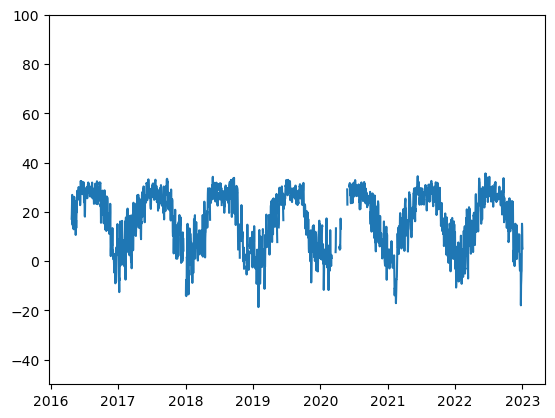

In [191]:
plt.plot(df['t_avg'].groupby(d.df.index.dayofyear/365+d.df.index.year).max())
plt.ylim([-50,100])

In [192]:
# convert to internal names, copy dataframe
df = d.df.rename(columns=d.inv_map)
# day of year mean of input energy balance components
vars_we_want = ['H', 'LE', 'Rn', 'G']
doy_means = df[vars_we_want].groupby(d.df.index.dayofyear/365+d.df.index.year).mean()
# create a Bokeh figure
fig = figure(x_axis_label='day of year', y_axis_label='day of year mean (w/m2)')
# arguements needed for creating interactive plots
plt_vars = vars_we_want
colors = ['red', 'blue', 'black', 'green']
x_name = 'date'
source = ColumnDataSource(doy_means)
Plot.add_lines(fig, doy_means, plt_vars, colors, x_name, source, labels=vars_we_want,
    x_axis_type=None) 
show(fig)

(-5.0, 5.0)

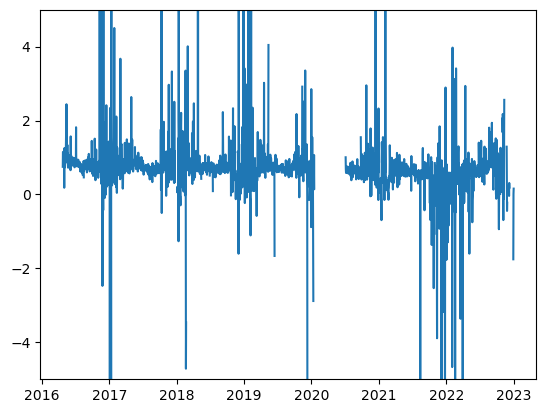

In [203]:
EBR = (doy_means['LE']+doy_means['H'])/(doy_means['Rn']-doy_means['G'])


plt.plot(EBR)
plt.ylim([-5, 5])

Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 4 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Filtering days with less then 80.0% or 77/96 sub-daily measurements


KeyError: "['Rn'] not in index"

Text(0, 0.5, 'Rn-G')

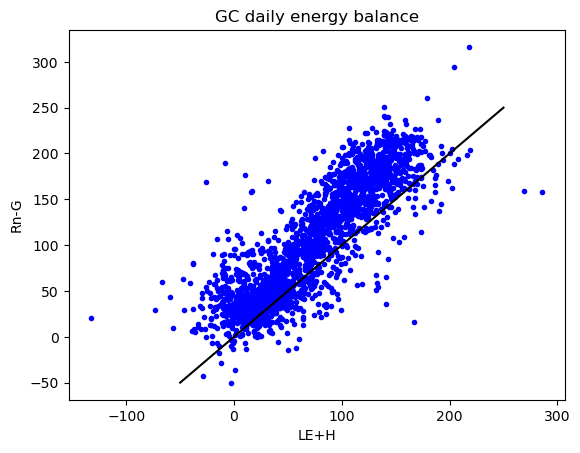

In [209]:
plt.plot(doy_means['LE']+doy_means['H'],doy_means['Rn']-doy_means['G'],'.b')
plt.plot([-50,250],[-50,250],'-k')
plt.title('GC daily energy balance')
plt.xlabel('LE+H')
plt.ylabel('Rn-G')


**See Also:** some routines occur automatically when creating a ``Data`` object, including calcuation of weighted and non-weighted averages of soil heat flux and soil moisture which is described in [Averaging data from multiple sensors](https://flux-data-qaqc.readthedocs.io/en/latest/advanced_config_options.html#averaging-data-from-multiple-sensors).

#### Modifying input data

A last note on the ``Data`` object (same goes for the ``QaQc`` object) is that ``Data.df`` is a class property, in this case that means that it can be reassigned with a different ``pandas.DataFrame``. This is critical for manual pre-filtering and validation of data before proceeding with energy balance closure routines. A simple example is shown here:

In [20]:
# add 5 to air temperature, this would effect ET calculations later
#x = d.df
#x['T_SONIC'] += 5
#d.df = x

A realistic use of the reassignability of the ``Data.df`` and ``QaQc.df`` properties is shown in [manual cleaning of poor quality data](https://flux-data-qaqc.readthedocs.io/en/latest/closure_explanation.html#step-0-manual-cleaning-of-poor-quality-data).

**See Also:** The ``Data.apply_qc_flags`` method allows for reading in quality control flags with the input data and filtering specific data out based on user-defined numeric or character flags. This routine is specific to ``Data`` and includes several attributes that are added to a ``Data`` instance, for full explanation and examples see [Quality-based data filtering](https://flux-data-qaqc.readthedocs.io/en/latest/advanced_config_options.html#quality-based-data-filtering).

**Hint:** the plot methods of ``Data`` and ``QaQc`` objects have the keyword argument ``output_type`` which by default is set to "save", the other two options are "notebook" for showing within a Jupyter Notebook and "show" which opens a temporary file in the default web browser.  

If you rather save the plot, and maybe you want 2 columns of plots,

## Visualize input data

The ``Data.plot`` method create a series of interactive time series plots of input data, potential plots inlcude:

* energy balance components 
* radiation components 
* multiple soil heat flux measurements
* air temperature
* vapor pressure and vapor pressure deficit
* wind speed
* precipitation 
* latent energy
* multiple soil moisture measurements

If any of these variables are not found the plot(s) will not be added.

The most useful interactive features of plots created by ``flux-data-qaqc`` are:

* pan/zoom
* hover tolltips on var names, values, date
* linked x-axes on time series plots
* save plot option (can save specific subplot zoomed in)

Here is an example,

After saving a plot without specifying the output file path (keyword argument `out_file`), it will be saved to an "output" directory where the config file is with the file name based on ``Data.site_id`` with the suffix "\_input_plots":

In [210]:
#d.plot(output_type='notebook', plot_width=700)
#d.plot(output_type='notebook')

Shortwave and potential clear sky radiation time series grapths missing all variables
Evapotranspiration time series grapths missing all variables
Fraction of reference ET time series grapths missing all variables
Energy balance ratio time series grapths missing all variables
Energy balance scatter grapths missing all variables
Latent energy scatter grapths missing all variables
Evapotranspiration scatter grapths missing all variables


TypeError: gridplot() got an unexpected keyword argument 'width'

**Hint:** The ``QaQc.plot`` method shown below is similar however it may include added plots with calculated and corrected variables (if they exist) and will always plot data in daily and monthly temporal frequency because daily frequency is required before applying ``flux-data-qaqc`` energy balance closure corrections.

## Temporal resampling

The ``QaQc`` object holds several tools for managing data and eddy covariance data analysis, but one of it's primary features is temporal resampling of input data to daily and monthly frequencies. The resampling of time series data to daily frequency occurs upon the creation of a ``QaQc`` instance if the frequency within the preceeding ``Data`` object is not already daily:

In [211]:
# the frequency of the input data is 30 minute
d.df.index[0:5]

DatetimeIndex(['2016-04-22 11:15:00', '2016-04-22 11:30:00',
               '2016-04-22 11:45:00', '2016-04-22 12:00:00',
               '2016-04-22 12:15:00'],
              dtype='datetime64[ns]', name='date', freq=None)

In [212]:
# creating a QaQc instance will automatically convert to daily
d = Data('GC_config.ini.txt')
q = QaQc(d)

Calculating mean for var: THETA from columns: ['D5TE_VWC_5cm_Avg', 'D5TE_VWC_15cm_Avg']
Calculating vapor pressure from vapor pressure deficit and air temperature
Calculating dew point temperature from vapor pressure
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 4 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Filtering days with less then 100.0% or 96/96 sub-daily measurements


In [213]:
# first 5 datetime indices are dates now
q.df.index[0:5]

DatetimeIndex(['2016-04-22', '2016-04-23', '2016-04-24', '2016-04-25',
               '2016-04-26'],
              dtype='datetime64[ns]', name='date', freq='D')

The method used for aggregating different variables, e.g. mean or sum, when resampling to daily or monthly frequency is defined in the ``QaQc.agg_dict`` class attribute:

In [214]:
# these are the internal names as keys and temporal aggregation method as values
QaQc.agg_dict

{'ASCE_ETo': 'sum',
 'ASCE_ETr': 'sum',
 'energy': 'mean',
 'flux': 'mean',
 'flux_corr': 'mean',
 'br': 'mean',
 'ET': 'sum',
 'ET_corr': 'sum',
 'ET_gap': 'sum',
 'ET_fill': 'sum',
 'ET_fill_val': 'sum',
 'ET_user_corr': 'sum',
 'ebr': 'mean',
 'ebr_corr': 'mean',
 'ebr_user_corr': 'mean',
 'ebr_5day_clim': 'mean',
 'gridMET_ETr': 'sum',
 'gridMET_ETo': 'sum',
 'gridMET_prcp': 'sum',
 'lw_in': 'mean',
 't_avg': 'mean',
 't_max': 'mean',
 't_min': 'mean',
 't_dew': 'mean',
 'rso': 'mean',
 'sw_pot': 'mean',
 'sw_in': 'mean',
 'vp': 'mean',
 'vpd': 'mean',
 'ppt': 'sum',
 'ppt_corr': 'sum',
 'ws': 'mean',
 'Rn': 'mean',
 'Rn_subday_gaps': 'sum',
 'rh': 'mean',
 'sw_out': 'mean',
 'lw_out': 'mean',
 'G': 'mean',
 'G_subday_gaps': 'sum',
 'LE': 'mean',
 'LE_corr': 'mean',
 'LE_subday_gaps': 'sum',
 'LE_user_corr': 'mean',
 'H': 'mean',
 'H_corr': 'mean',
 'H_subday_gaps': 'sum',
 'H_user_corr': 'mean'}

**Note:** there are several calculated variables above that may not look familiar, many are calculated by the energy balance closure correction routines and described in [Closure Algorithms](https://flux-data-qaqc.readthedocs.io/en/latest/closure_explanation.html#). Also, any other variables (not found in ``QaQc.agg_dict`` that exist in a ``QaQc.df`` before accessing ``QaQc.monthly_df`` the first time will be averaged in the monthly time series dataframe (``QaQc.monthly_df``).

If the inferred input frequency was accurate you will see a [Pandas datetime alias](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases), in this case '30T' is thirty minutes. If the temporal frequency is not automatically detected you should be able to rely on the ``n_samples_per_day`` instance attribute that is manually estimated by the ``QaQc`` constructor:

In [56]:
q.n_samples_per_day

96

#### Filter days with sub-daily gaps

The ``drop_gaps`` and ``daily_frac`` keyword arguments used when creating a ``QaQc`` instance allow you to control how days with sub-daily measurement gaps will or will not be filtered out when resampling to daily frequency. 

Sub-daily gaps in energy balance variables $LE$, $H$, $Rn$, and $G$ can be linearly interpolated up to a certain gap length measured in hours, with options to control the longest length of gap to interpolate when $Rn \ge 0$ controlled by the ``QaQc`` keyword argument ``max_interp_hours`` (default 2 hours) and the longest gap to interpolate when $Rn < 0$ set by the ``max_interp_hours_night`` (default 4 hours). 

**Important:** By default the ``QaQc`` constructor will first linearly interpolate energy balance variables ($LE$, $H$, $Rn$, and $G$) according to the maximum gap lengths (``max_interp_hours`` and ``max_interp_hours_night``) and then count sub-daily gaps and drop days (set values to null) for all climate data columns (not QC flag or sub-daily gap count columns) where any of the sub-daily data are missing because by default ``drop_gaps=True`` and ``daily_frac=1.0``. In other words, if you have hourly input data for $LE$ and one hour was missing on a given day, by default that hour will be linearly interpolated before calculating the daily time series and the daily mean will be calculated after. On the other hand, if other climate variables had a single hour missing on a given day, e.g. wind direction or air temperature, this day would be filtered out by the ``QaQc`` constructor. This is important because the daily time series is what is used in all energy balance closure correction algorithms. 

The percentage of sub-daily samples to require set by the ``daily_frac`` argument and the maximum length of gaps to linearly interpolate set by ``max_interp_hours`` and ``max_interp_hours_night`` complement each other and are used in tandem. For example, if the input data is half-hourly and you only want a maximum of 4 hours to be interpolated on any given day and gap lengths to interpolate should be no more than 2 hours each then you would pass the following parameters to the ``QaQc`` constructor:

In [215]:
q = QaQc(d, daily_frac=18/24, max_interp_hours=2, max_interp_hours_night=6)

Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 6 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Filtering days with less then 75.0% or 72/96 sub-daily measurements


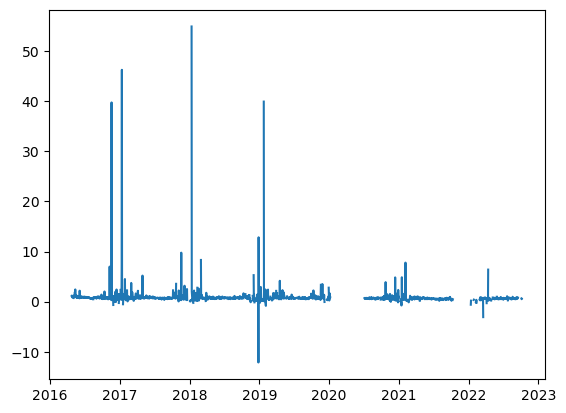

In [228]:
q.df.columns

#daily_df = q.df

EBR = (daily_df['LE_li_wpl']+daily_df['Hc_li'])/(daily_df['Rn_corr']-daily_df['shf_Avg(2)'])
plt.plot(EBR)

In [233]:
q2 = q.correct_data()
q2


Missing one or more energy balance variables, cannot perform energy balance correction.



/Users/allison/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/allison/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


/Users/allison/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/allison/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


/Users/allison/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/Users/allison/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


Gap filling ET with filtered ETrF x ETr (gridMET)


In this case we set ``daily_frac=20/24`` because we are only allowing a maximum of 4 hours of total gaps in the day in other words we are requiring 40 of the 48 half hourly samples to exist before we filter out a day. Remember, because linear interpolation of gaps is done before counting sub-daily gaps, this could result in retaining days with more than 4 hours of gaps in the original time series of energy balance components. You may also pass the ``daily_frac`` arugment as a decimal fraction, e.g. $0.8333 \approx 20/24$.

Let's view a comparison of $Rn$ using different options of filtering days with sub-daily gaps in the working dataset, because it has several periods of systematic gaps which cause upwards skewing of daily mean $Rn$ if not filtered carefully:

In [60]:
# make an empty pandas dataframe for Rn series
Rn_df = pd.DataFrame()
# recreate multiplt QaQc instances using different sub-day gap filters
q = QaQc(d, drop_gaps=False, max_interp_hours=None)
Rn_df['sub_day_gaps'] = q.df.Rn_subday_gaps
Rn_df['no_filter_no_interp'] = q.df.rename(columns=q.inv_map).Rn
q = QaQc(d, drop_gaps=False)
Rn_df['no_filter_with_interp'] = q.df.rename(columns=q.inv_map).Rn
q = QaQc(d, daily_frac=0.5) # filter days with less than 50% data
Rn_df['require_50'] = q.df.rename(columns=q.inv_map).Rn
q = QaQc(d, daily_frac=0.75)
Rn_df['require_75'] = q.df.rename(columns=q.inv_map).Rn
q = QaQc(d, daily_frac=1, max_interp_hours=24, max_interp_hours_night=24) 
Rn_df['require_100_with_interp'] = q.df.rename(columns=q.inv_map).Rn
q = QaQc(d, daily_frac=1, max_interp_hours=None) 
Rn_df['require_100_no_interp'] = q.df.rename(columns=q.inv_map).Rn

Data is being resampled to daily temporal frequency.
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 4 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 4 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Filtering days with less then 50.0% or 48/96 sub-daily measurements
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 4 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Filtering days with less then 75.0% or 72/96 sub-daily measurements
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 24 hours when Rn < 0 and up to 24 hours when Rn >= 0.
Filtering days with less then 100% or 96/96 sub-daily measurements
Data is being resampled to daily temporal frequency.
Filtering days wi

In [61]:
# plot to compare results of day-gap filter
fig = figure(x_axis_label='date', y_axis_label='mean daily net radiation (w/m2), filtered based on sub-daily gaps')
# arguments needed for creating interactive line plots
colors = ['red', 'darkred','orange', 'blue', 'black', 'tan']
plt_vars = ['no_filter_no_interp', 'no_filter_with_interp', 'require_50', 'require_75', 'require_100_with_interp', 'require_100_no_interp']
labels = ['no filter wout/interp.', 'no filter w/interp.', 'require > 50% w/interp.', 'require > 75% w/interp.', 'require 100% w/interp.', 'require 100% wout/interp.']
x_name = 'date'
source = ColumnDataSource(Rn_df)
Plot.add_lines(fig, Rn_df, plt_vars, colors, x_name, source, labels=labels) 
# add daily gap counts to secondary y
fig.extra_y_ranges['gap_counts'] = Range1d(start=0, end=48)
fig.add_layout(LinearAxis(y_range_name='gap_counts', axis_label='number of sub-daily gaps'), 'right')
fig.circle('date', 'sub_day_gaps', legend_label='n sub-day gaps', y_range_name='gap_counts',
    color='silver', source=source
)
fig.hover[0].tooltips.append(('sub_day_gaps','@{}'.format('sub_day_gaps')))
fig.legend.location = 'top_right'
show(fig)

Try zooming in on the gaps filled by the "no filter wout/interp." line to compare which days are retained/filtered by different options, also remove lines by clicking on them in the legend to compare subsets of options.

**Tip:** for a more fine-grained approach to filtering out days where perhaps multiple 2 hour gaps were filled use the newly created daily gap count columns: "LE_subday_gaps", "H_subday_gaps", "Rn_subday_gaps", and "G_subday_gaps".

In [63]:
q = QaQc(d)
df = q.df.rename(columns=q.inv_map)

Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 4 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Filtering days with less then 100.0% or 96/96 sub-daily measurements


In [72]:
df.columns

Index(['t_dew', 'sw_out', 'lw_out', 'vpd', 'theta_2', 'LE', 'lw_in', 'vp',
       'rh', 't_avg', 'theta_mean', 'es', 'ws', 'G', 'H', 'Rn', 'theta_1',
       'wd', 'sw_in', 't_min', 't_max', 'H_subday_gaps', 'LE_subday_gaps',
       'Rn_subday_gaps', 'G_subday_gaps'],
      dtype='object')

For example, you could post-filter out days in any given energy balance variable, in this case $Rn$ where sub-daily gaps exceed a threshold. 

In [66]:
df.loc[(df.LE_subday_gaps > 2) & (df.LE.notna()), ['Rn','Rn_subday_gaps']]

,Rn,Rn_subday_gaps
date,,
2016-04-27,125.448545,0.0
2016-04-28,282.671350,0.0
2016-05-04,335.064454,0.0
2016-05-07,247.651332,0.0
2016-05-12,159.091353,0.0
...,...,...
2022-11-13,180.794899,0.0
2022-11-14,224.220975,0.0
2022-11-15,48.479764,0.0


#### Monthly time series

The ``QaQc.monthly_df`` property allows for creating the monthly time series of input anc calculated variables provided by ``QaQc.correct_data``. It uses the same temporal aggregation methods as the daily time series i.e. from ``QaQc.agg_dict``. Although there are many similarities there are important differences between ``QaQc.df`` and ``QaQc.monthly_df`` other than the obvious: when accessing the ``QaQc.monthly_df`` it will automatically run the default energy balance closure correction routine provided by ``QaQc.correct_data`` *if* it has not yet been run. You can check if it has been run at anytime by:

In [84]:
q.corrected

False

To show how this works let's access the monthly data and show the monthly statistics of the "corrected" evapotranspiration (ET_corr):

In [85]:
# first note, ET_corr is not in the dataset yet
'ET_corr' in q.df.columns

False

Now access the monthly time series,

In [92]:
q.df.columns

Index(['t_dew', 'Short_dn_corr', 'Long_dn_corr', 'VPD', 'D5TE_VWC_15cm_Avg',
       'LE_li_wpl', 'Long_up_corr', 'vp', 'RH_tmpr_rh_mean', 'T_tmpr_rh_mean',
       'theta_mean', 'es', 'rslt_wnd_spd', 'shf_Avg(2)', 'Hc_li',
       'D5TE_VWC_5cm_Avg', 'wnd_dir_compass', 'Short_up_corr', 't_min',
       't_max', 'H_subday_gaps', 'LE_subday_gaps', 'Rn_subday_gaps',
       'G_subday_gaps', 'rso', 'ET', 'gridMET_ETr', 'gridMET_ETo',
       'gridMET_prcp', 'ETrF', 'ETrF_filtered', 'ET_fill', 'ET_gap',
       'ET_fill_val'],
      dtype='object')

In [74]:
q.monthly_df;
'ET_corr' in q.df.columns

False

In [91]:
q.monthly_df

,Short_dn_corr,Long_dn_corr,LE_li_wpl,Long_up_corr,RH_tmpr_rh_mean,rslt_wnd_spd,shf_Avg(2),D5TE_VWC_5cm_Avg,rso,t_dew,...,gridMET_prcp,ET,Rn_subday_gaps,ET_gap,G_subday_gaps,ET_fill_val,gridMET_ETr,LE_subday_gaps,gridMET_ETo,H_subday_gaps
date,,,,,,,,,,,,,,,,,,,,,
2016-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-31,39.486904,406.855452,NaN,351.290613,67.207148,5.481566,3.590489,0.257401,347.511903,9.684083,...,118.700005,79.315325,0.0,8.0,0.0,NaN,176.899994,217.0,136.500000,216.0
2016-06-30,56.448622,450.017433,116.960477,383.244011,63.395488,4.464049,9.689978,0.248294,364.369442,15.565684,...,124.500000,121.727998,0.0,3.0,1.0,NaN,217.000000,77.0,172.300003,67.0
2016-07-31,40.567586,444.543321,NaN,400.577844,81.037747,3.510973,6.147413,NaN,353.490689,19.602367,...,208.199997,120.612176,4.0,19.0,4.0,NaN,168.500000,256.0,147.600006,234.0
2016-08-31,22.136783,448.240861,NaN,409.094126,80.090282,3.306222,7.486521,NaN,315.565685,19.885303,...,160.800003,113.750772,148.0,10.0,148.0,NaN,151.000000,267.0,130.300003,265.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,24.022039,446.014807,NaN,396.996073,73.708413,3.932217,6.931548,0.205163,354.274827,18.358217,...,43.400002,105.624241,0.0,13.0,0.0,NaN,196.000000,432.0,163.000000,514.0
2022-08-31,25.329762,433.624811,NaN,386.445724,77.148168,3.696936,3.673510,0.237909,317.176115,17.799675,...,108.900002,87.286659,0.0,14.0,0.0,NaN,178.199997,560.0,142.800003,648.0
2022-09-30,22.204564,410.515702,NaN,361.944570,72.141025,3.949390,-2.341535,0.223997,259.280141,13.643515,...,59.700001,55.454406,3.0,11.0,3.0,NaN,154.699997,340.0,117.000000,463.0


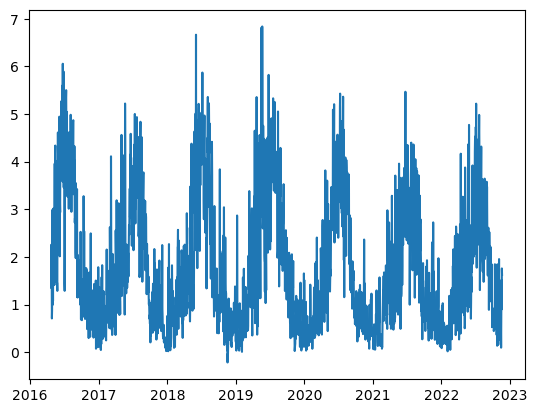

In [89]:
m = q.monthly_df

import matplotlib.pyplot as plt

plt.plot(q.df.ET)

By calling the monthly dataframe, the energy balance closure was applied automatically

In [75]:
q.monthly_df.ET_corr.describe()

AttributeError: 'DataFrame' object has no attribute 'ET_corr'

In [ ]:
q.corrected

**Note:** The ``QaQc.monthly_df`` also filters out months with less than 30% of days of the month missing by default. To calculate monthly time series with other threshold fractions of days required use the ``util.monthly_resample`` function and adjust the keyword argument ``thresh`` which is the fraction (0-1) of days of the month required to not be gaps otherwise the month's value will be forced to null, e.g. if you wanted to caclulate the monthly mean air temperature requiring 30 and 90 percent of the days in the month to not be gaps:

In [42]:
from fluxdataqaqc.util import monthly_resample
# select just t_avg for example
cols = ['t_avg'] 
df = q.df.rename(columns=q.inv_map)
# create temporary df with different monthly resample results
tmp_df = monthly_resample(df, cols, 'mean', thresh=0.9).rename(
    columns={'t_avg': 'thresh_90'}
)
# join temp dataframe with monthly resample results using different thresh
monthly_gap_comp = tmp_df.join(monthly_resample(df, cols, 'mean', thresh=0.3).rename(
    columns={'t_avg': 'thresh_30'})
)
# plot to compare results of day-gap filter
fig = figure(x_axis_label='date', y_axis_label='monthy mean air temperature (C), filtered based on daily gaps')
# arguments needed for creating interactive line plots
x = 'date'
source = ColumnDataSource(monthly_gap_comp)
# this example also shows how to use other Bokeh plot arguments
Plot.line_plot(fig,'date','thresh_30',source,'red',label='require > 30%', line_alpha=0.5) 
Plot.line_plot(fig,'date','thresh_90',source,'black',label='require > 90%',line_dash='dotted', line_width=2) 
fig.legend.location = 'top_right'
show(fig)

## Energy balance corrections 

``flux-data-qaqc`` provides routines that adjust turbulent heat fluxes (latent and sensible) to improve surface energy balance closure of eddy covariance flux station data. These routines ultimately result in a corrected daily and monthly time series of latent energy, sensible heat, and evapotranspiration with the option to gap-fill days in corrected ET with ET calculated from gridMET reference ET and fraction of reference ET.

There are two methods currently implemented:
1. Energy Balance Ratio method (default), modified from the [FLUXNET method](https://fluxnet.fluxdata.org/data/fluxnet2015-dataset/data-processing/)
2. Bowen Ratio approach (forces closure)

Detailed descriptions of both methods including ET gap-filling methods can be found in the online documentation [Closure Algorithms](https://flux-data-qaqc.readthedocs.io/en/latest/closure_explanation.html#closure-methodologies) page. A few important notes on the API of these methods and other hydro-climatic statistical variables that are calculated are shown below.

The ``QaQc.correct_data`` method is used to run energy balance closure corrections. Here are a few tips on using them,

In [37]:
# note above the monthly_df automatically applied the 'ebr' Energy Balance Ratio correction
q.corr_meth

'ebr'

In [38]:
# potential correction options
q.corr_methods

('ebr', 'br', 'lin_regress')

In [39]:
# to specify the Bowen Raito method:
q.correct_data(meth='br')

gridMET reference ET already downloaded for station at:
/Users/allison/Dropbox/UCDenver/Github/flux-data-qaqc/examples/Basic_usage/gridMET_data/US-Tw3_38.1083N_-121.6417W.csv
not redownloading.
Gap filling ET_corr with filtered ETrF x ETr (gridMET)


In [40]:
# the most recently used correction method is now shown
q.corr_meth

'br'

**Tip:** after applying any energy balance closure correction routine all previous corrected variables will be overwritten or dropped in ``QaQc.df``, ``QaQc.monthly_df``, and ``QaQc.variables``, therefore to make a comparison of different methods on the same data make a copy of the ``df`` or ``monthly_df`` properties before running the next correction, e.g.

In [41]:
# make copies of daily results of different correction options
q.correct_data(meth='ebr')
ebr_gapfilled = q.df
q.correct_data(meth='ebr', et_gap_fill=False)
ebr_notgapfilled = q.df
q.correct_data(meth='br')
br_gapfilled = q.df
q.correct_data(meth='br', et_gap_fill=False)
br_notgapfilled = q.df

gridMET reference ET already downloaded for station at:
/Users/allison/Dropbox/UCDenver/Github/flux-data-qaqc/examples/Basic_usage/gridMET_data/US-Tw3_38.1083N_-121.6417W.csv
not redownloading.
Gap filling ET_corr with filtered ETrF x ETr (gridMET)
gridMET reference ET already downloaded for station at:
/Users/allison/Dropbox/UCDenver/Github/flux-data-qaqc/examples/Basic_usage/gridMET_data/US-Tw3_38.1083N_-121.6417W.csv
not redownloading.
Gap filling ET_corr with filtered ETrF x ETr (gridMET)


#### ET gap-filling

A few notes on the option that uses reference ET and fraction of daily reference ET to fill in large gaps in corrected ET, i.e. the keyword argument ``QaQc.correct_data(etr_gap_fill = True)``. 

* The nearest [gridMET](http://www.climatologylab.org/gridmet.html) cell's time series data for precipitation and alfalfa reference ET is attempted to be downloaded if it is not found in the ``gridmet_file_path`` entry of the config.ini file. 

* If the path to a gridMET file is not found it is re-downloaded, the config file will be updated with the new path and resaved. 

* Only the overlapping time period that matches the eddy covariance time series data is attempted to be downloaded, i.e. the period in ``QaQc.df.index``. 

* When a gridMET file is downloaded it will always be saved in a subdirectory where the config file is located called "gridMET_data" and named using the ``QaQc.site_id`` and gridMET cell centroid latitude and longitude.

* Corrected latent energy ($LE_{corr}$) gaps are also backwards filled from gap-filled ET.


**Caution:** [gridMET](http://www.climatologylab.org/gridmet.html) only exists within the contiguous United States and from 1979 to present, therefore if your station lies outside of this region or you are analyzing eddy flux data recorded before 1979 this option will not be ususable and you should always run corrections with ``etr_gap_fill=False`` to avoid potential errors.

Lastly, although variables created by energy balance closure corrections are described in [Closure Algorithms](https://flux-data-qaqc.readthedocs.io/en/latest/closure_explanation.html#closure-methodologies). For reference here is a list of all possible variables created by the Energy Balance Ratio correction algorithm:

```
rso : potential clear sky radiation (ASCE formulation)
flux : input LE + H
energy : input Rn - G
ebr_5day_clim : 5 day climatology of the filtered Energy Balance Ratio 
LE_corr : corrected latent energy
ebc_cf  : energy balance closure correction factor (inverse of ebr_corr)
ebr_corr : corrected energy balance ratio
flux_corr : LE_corr + H_corr 
ebr : input energy balance ratio
H_corr : corrected sensible heat
ET : ET calculated from input LE and average air temperature
ET_corr : ET calculated from LE_corr and avg. air temp.
gridMET_ETr : gridMET alfalfa reference ET (nearest cell)
gridMET_prcp : gridMET precipitation
ETrF : fraction of reference ET for ET_corr, i.e. ET_corr / gridMET_ETr
ETrF_filtered : filtered ETrF
ET_fill : gridMET_ETr * ETrF_filtered (to fill gaps in ET_corr, full time series)
ET_gap : True on gap days in ET_corr, False otherwise (for plotting and post-processing)
ET_fill_val : value of ET_fill on gap days (for plotting and post-processing)
```

The Bowen Ratio correction method will produce the 'br' variable which is the Bowen Ratio. 

## Other calculations

By default, ``QaQc.correct_data`` also calculates ET from input latent energy (LE) and air temperature, corrected ET from corrected LE and air temperature, potential clear sky radiation (ASCE formulation), and the ``Data`` object attempts to calculate vapor pressure deficit from vapor pressure and air temperature or vapor pressure from vapor pressure deficit and air temperature if they exist at hourly or shorter temporal frequency. 

#### Evapotranspiration

The evapotranspiration (ET) calculations are described in [Step 8 of the energy balance ratio closure algorithm](https://flux-data-qaqc.readthedocs.io/en/latest/closure_explanation.html#steps-7-and-8-correct-turbulent-fluxes-ebr-and-et). 

#### ASCE clear sky radiation

Daily ASCE potential clear sky radiation ($R_{so}$) is calculated using equation 19 in the "ASCE Standardized Reference Evapotranspiration Equation" final report by the Task Committee on Standardization of Reference Evapotranspiration Environmental and Water Resources Institute of the American Society of Civil Engineers January, 2005 [here](https://www.mesonet.org/images/site/ASCE_Evapotranspiration_Formula.pdf). This calculation is a simple method based primarily on elevation and latitude which results in a theoretical envelope of $R_{so}$ as a function of the day of the year,

$$ R_{so} = \left(5 + 2 \times 10^{-5} z \right) R_a $$

where $z$ is elevation in meters and $R_a$ is daily extraterrestrial radiation (radiation with in the absence of an atmosphere), which itself is a well-behaved function of solar declination, the day of the year and the solar constant (see equations 21-29 in the [ASCE report](https://www.mesonet.org/images/site/ASCE_Evapotranspiration_Formula.pdf)). 

#### Vapor pressure/deficit

The ``Data`` object will attempt to calculate vapor pressure or vapor pressure deficit if one exists but not the other and average air temperature time series also exists with the input data at hourly or shorter temporal frequency. The Magnus equation (eqn. 37 in the ASCE report) states that the saturation vapor pressure ($es$) in kPa relates to air temperature,

$$ es = 0.6108  e^{\left(\frac{17.27 \cdot T}{(T + 237.3)}\right)} $$

where $T$ is average hourly air temperature in degrees celcius. Vapor pressure deficit ($vpd$) is,

$$ vpd = es - ea$$,

where $ea$ is actual vapor pressure in kPa. **Note,** The equations above are defined for hourly data however they are used for hourly or shorter mean variables ($T$, $ea$, or $vpd$) within ``flux-data-qaqc`` and then converted to daily means, if they are not present in the input data at hourly or shorter frequencies then they are not calculated.

The above equations can be rearanged to solve for either $es$ or $vpd$ given the other variable and air temperature.  For example, if given $T$ and $vpd$, then to get actual vapor pressure

$$ es = 0.6108  e^{\left(\frac{17.27 \cdot T}{(T + 237.3)}\right)}  $$

$$ ea = es - vpd. $$

In ``flux-data-qaqc`` actual vapor pressure is named "vp" not "ea".

## A note on units

Upon creation of a ``QaQc`` object, variables are checked for valid input units and converted to required units needed for internal calculations when running ``QaQc.correct`` and for certain default plots (see below). For a list of valid input units for different variables refer to the ``QaQc.allowable_units`` attribute:

In [48]:
q.allowable_units

{'LE': ['w/m2', 'mj/m2'],
 'H': ['w/m2', 'mj/m2'],
 'Rn': ['w/m2', 'mj/m2'],
 'G': ['w/m2', 'mj/m2'],
 'lw_in': ['w/m2', 'mj/m2'],
 'lw_out': ['w/m2', 'mj/m2'],
 'sw_in': ['w/m2'],
 'sw_out': ['w/m2', 'mj/m2'],
 'ppt': ['mm', 'in', 'm'],
 'vp': ['kpa', 'hpa', 'pa'],
 'vpd': ['kpa', 'hpa', 'pa'],
 't_avg': ['c', 'f', 'k'],
 't_min': ['c', 'f', 'k'],
 't_max': ['c', 'f', 'k'],
 'ws': ['m/s', 'mph']}

For each variable above, if given one of the units allowable the units will automatically be converted to the required units.

To know which variables are required to be in particular units view ``QaQc.required_units``:

In [49]:
q.required_units

{'LE': 'w/m2',
 'H': 'w/m2',
 'Rn': 'w/m2',
 'G': 'w/m2',
 'lw_in': 'w/m2',
 'lw_out': 'w/m2',
 'sw_in': 'w/m2',
 'sw_out': 'w/m2',
 'ppt': 'mm',
 'vp': 'kpa',
 'vpd': 'kpa',
 't_avg': 'c',
 't_min': 'c',
 't_max': 'c',
 'ws': 'm/s'}

**Note:** the list of allowable units is a work in progress, if your input units are not available consider raising an issue on [GitHub](https://github.com/Open-ET/flux-data-qaqc/issues) or providing the conversion directly with a pull request. Automatic unit conversions are handled within the ``util.Convert`` class using the ``util.Convert.convert`` class method. 

## Save resampled and corrected data

The ``QaQc.write`` method conveniently writes daily and monthly time series of input and calculated variables to comma separated value (CSV) files. If the ``QaQc.correct_data`` method has not yet been run it will be and the monthly time series will also be created using the default parameters for the correction routine (Energy Balance Ratio method with ETr-based gap filling). 

The default output directory for time series files can be accessed/changed by the ``out_dir`` attribute, if not changed it will be located in the same directory of the config.ini file. The daily and monthly time series file names will begin with the ``QaQc.site_id`` followed by "daily_data" or "monthly_data" resepctively. For example,

In [50]:
# new QaQc instance
q = QaQc(d)
# a platform dependent pathlib.Path object
q.out_dir


The input data temporal frequency appears to be less than daily.
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 4 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Filtering days with less then 100.0% or 48/48 sub-daily measurements


PosixPath('/home/john/flux-data-qaqc/examples/Basic_usage/output')

The line below shows that no output files have been written to ``QaQc.out_dir`` yet,

In [51]:
# print files in output directory that begin with the site_id
[f.name for f in q.out_dir.glob('{}*'.format(q.site_id))]

['US-Tw3_daily_data.csv', 'US-Tw3_monthly_data.csv', 'US-Tw3_input_plots.html']

In [52]:
q.corrected

False

In [53]:
# writing files also ran corrections since they were not yet run
q.write()

gridMET reference ET already downloaded for station at:
/home/john/flux-data-qaqc/examples/Basic_usage/gridMET_data/US-Tw3_38.1083N_-121.6417W.csv
not redownloading.
Gap filling ET_corr with filtered ETrF x ETr (gridMET)


In [54]:
q.corrected

True

Now the respective daily and monthl time series have been written to ``QaQc.out_dir``,

In [55]:
[f.name for f in q.out_dir.glob('{}*'.format(q.site_id))]

['US-Tw3_daily_data.csv', 'US-Tw3_monthly_data.csv', 'US-Tw3_input_plots.html']

**Hint:** you can overwrite the default name of the output directory to save the daily and monthly time series using the ``out_dir`` keyword argument to ``QaQc.write``, this option keeps the location within the directory of the config file but just changes the name, whereas to change the entire output directory path adjust the ``QaQc.out_dir`` attribute directly. Also, the naming scheme of output files created will use user-defined names for all input variables.

## Visualize resampled and corrected data

Similar to the ``Data.plot``, the ``QaQc.plot`` method creates a series of defualt validation time series and scatter plots of input and in this case calculated variables. The temporal frequency of plots from ``QaQc.plot`` will always be daily and monthly and additional plots are created for validation of energy balance closure corrections, otherwise the same options such as number of subplot columns, super title, subplot dimensions, output type, output file path, etc. are available. Similar to ``QaQc.write`` and ``QaQc.monthly_df``, if the data has not yet been corrected the ``plot`` method will correct it using the default parameters before creating the plots. 

In [42]:
q = QaQc(d, daily_frac=0.5)
q.corrected


The input data temporal frequency appears to be less than daily.
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 4 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Filtering days with less then 50.0% or 24/48 sub-daily measurements


False

In [43]:
q.plot(output_type='notebook', plot_width=700)

gridMET reference ET already downloaded for station at:
/Users/allison/Dropbox/UCDenver/Github/flux-data-qaqc/examples/Basic_usage/gridMET_data/US-Tw3_38.1083N_-121.6417W.csv
not redownloading.
Gap filling ET_corr with filtered ETrF x ETr (gridMET)


TypeError: gridplot() got an unexpected keyword argument 'width'

In [58]:
q.corrected

True